In [1]:
import pandas as pd
import numpy as np

df = pd.read_csv("../data/processed/cleaned_fashion_sales.csv")
df['date_purchase'] = pd.to_datetime(df['date_purchase'])

snapshot_date = df['date_purchase'].max() + pd.Timedelta(days=1)

rfm = df.groupby('customer_reference_id').agg({
    'date_purchase': lambda x: (snapshot_date - x.max()).days,  # Recency
    'item_purchased': 'count',                                   # Frequency
    'purchase_amount_(usd)': 'sum'                               # Monetary
}).reset_index()

rfm.columns = ['customer_id', 'recency', 'frequency', 'monetary']
rfm.head()

,customer_id,recency,frequency,monetary
0,3957,86,11,1150.0
1,3958,18,17,1334.0
2,3959,49,19,2047.0
3,3960,18,15,1434.0
4,3961,34,17,1811.0


In [3]:
product_revenue = df.groupby('item_purchased')['purchase_amount_(usd)'].sum().sort_values(ascending=False)

# ABC classification
total_revenue = product_revenue.sum()
abc = product_revenue.cumsum() / total_revenue

def classify_abc(x):
    if x <= 0.8:
        return 'A'
    elif x <= 0.95:
        return 'B'
    else:
        return 'C'

abc_class = abc.apply(classify_abc)
abc_df = pd.DataFrame({'revenue': product_revenue, 'abc_class': abc_class})
abc_df.head()

,revenue,abc_class
item_purchased,,
Tunic,17275.0,A
Jeans,13068.0,A
Pajamas,12798.0,A
Shorts,12702.0,A
Handbag,12668.0,A


In [5]:
df['week'] = df['date_purchase'].dt.isocalendar().week

weekly_sales = df.groupby(['item_purchased', 'week'])['purchase_amount_(usd)'].sum().reset_index()

volatility = weekly_sales.groupby('item_purchased')['purchase_amount_(usd)'].std().fillna(0)
volatility_df = pd.DataFrame({'volatility_score': volatility})
volatility_df.head()

,volatility_score
item_purchased,
Backpack,128.759856
Belt,671.411540
Blazer,750.815663
Blouse,660.842815
Boots,821.676513


In [7]:
# Define rule-based price adjustments
df['simulated_price'] = df.apply(
    lambda row: row['purchase_amount_(usd)'] * 1.1 if row['review_rating'] >= 4.5
    else row['purchase_amount_(usd)'] * 0.9 if row['review_rating'] < 3
    else row['purchase_amount_(usd)'],
    axis=1
)
df[['purchase_amount_(usd)', 'review_rating', 'simulated_price']].head()

,purchase_amount_(usd),review_rating,simulated_price
0,4619.0,3.0,4619.0
1,2456.0,2.0,2210.4
2,2102.0,4.1,2102.0
3,3126.0,3.2,3126.0
4,3003.0,4.7,3303.3


In [9]:
# Merge ABC and volatility data for inventory strategy
inventory_analysis = abc_df.merge(volatility_df, left_index=True, right_index=True)
inventory_analysis.reset_index(inplace=True)
inventory_analysis.rename(columns={'index': 'item_purchased'}, inplace=True)
inventory_analysis.head()

,item_purchased,revenue,abc_class,volatility_score
0,Tunic,17275.0,A,1127.043877
1,Jeans,13068.0,A,1026.742047
2,Pajamas,12798.0,A,735.944932
3,Shorts,12702.0,A,802.003068
4,Handbag,12668.0,A,823.926411


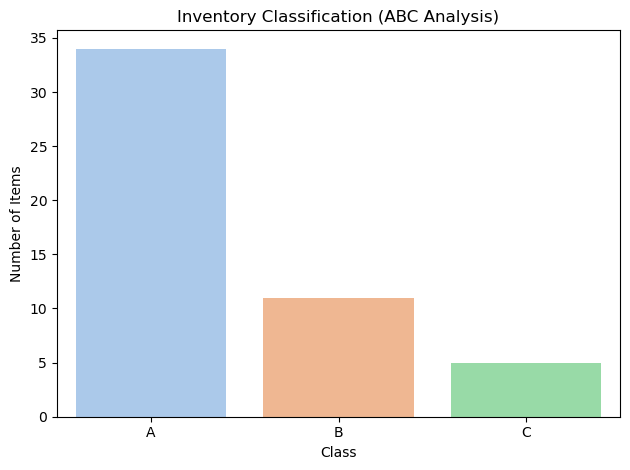

In [11]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=inventory_analysis, x='abc_class', order=['A', 'B', 'C'], palette='pastel')
plt.title("Inventory Classification (ABC Analysis)")
plt.xlabel("Class")
plt.ylabel("Number of Items")
plt.tight_layout()
plt.show()

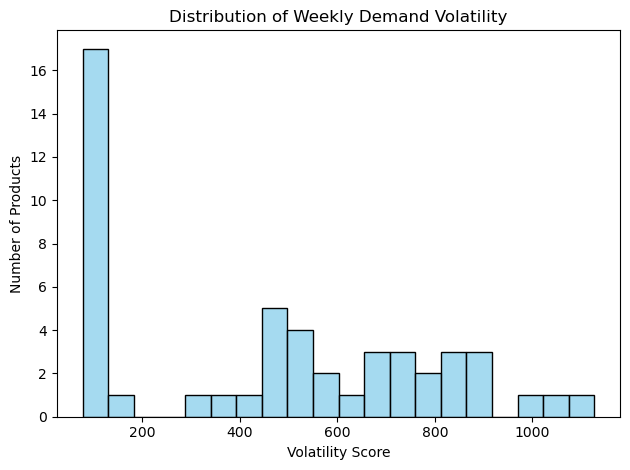

In [19]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
sns.histplot(inventory_analysis['volatility_score'], bins=20, color='skyblue')
plt.title("Distribution of Weekly Demand Volatility")
plt.xlabel("Volatility Score")
plt.ylabel("Number of Products")
plt.tight_layout()
plt.show()

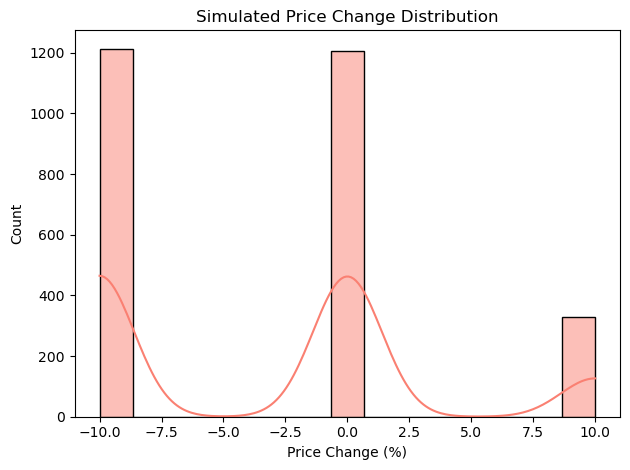

In [21]:
df['price_change_%'] = ((df['simulated_price'] - df['purchase_amount_(usd)']) / df['purchase_amount_(usd)']) * 100

sns.histplot(df['price_change_%'], bins=15, kde=True, color='salmon')
plt.title("Simulated Price Change Distribution")
plt.xlabel("Price Change (%)")
plt.tight_layout()
plt.show()

In [17]:
inventory_analysis.to_csv("../data/processed/inventory_strategy_summary.csv", index=False)
df.to_csv("../data/processed/simulated_pricing.csv", index=False)